In [1]:
# DI: uses conda activate NASEM_model_poetry_SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample
import numpy as np
import nasem_dairy as nd  

This is an example wrapper function that could be used with SAlib 'param_values' that are a matrix of new coeff_dict values.

after more context from SAlib docs, this is a new template: 

In [12]:
def wrapped_execute_model(X, coeffs_sampled, user_diet_in, animal_input_in, equation_selection_in, feed_library_in, default_coeff_dict=nd.coeff_dict, func=nd.execute_model):
    """
    Executes the specified model function with varying sets of coefficients and fixed model inputs, 
    returning an array of model outputs for sensitivity analysis.

    Parameters
    ----------
    X : ndarray
        A 2D numpy array where each row represents a set of sampled coefficient values to be evaluated.
    coeffs_sampled : list of str
        List of coefficient names corresponding to the columns in `X`. These are the coefficients being varied in the analysis.
    user_diet_in : dict
        Dictionary containing user-defined diet inputs for the model.
    animal_input_in : dict
        Dictionary containing animal-related inputs for the model.
    equation_selection_in : dict
        Dictionary specifying which equations to use within the model.
    feed_library_in : DataFrame 
        Data structure containing feed library information required by the model.
    default_coeff_dict : dict, optional
        The default dictionary of all coefficients used by the model, with keys as coefficient names and values as their default values. Default is `nd.coeff_dict`.
    func : function, optional
        The model function to be executed. This function should accept the model inputs as arguments and return a `ModelOutput` object. Default is `nd.execute_model`.

    Returns
    -------
    outputs : ndarray
        A 1D numpy array containing the model output of interest for each set of coefficients in `X`.

    Notes
    -----
    This function is designed to work with sensitivity analysis libraries like SALib. It takes samples of coefficient values generated by such a library, applies them to the model, and collects the outputs for analysis.

    The model function (`func`) is expected to return an object with a `get_value` method, which is used to extract the specific output of interest for sensitivity analysis.

    Examples
    --------
    >>> import numpy as np
    >>> from SALib.sample import saltelli
    >>> from nasem_dairy import execute_model, coeff_dict
    >>> 
    >>> problem = {
    ...     'num_vars': 3,
    ...     'names': ['coeff1', 'coeff2', 'coeff3'],
    ...     'bounds': [[0, 1], [0, 1], [0, 1]]
    ... }
    >>> param_values = saltelli.sample(problem, 100)
    >>> coeffs_sampled = problem['names']
    >>> 
    >>> outputs = wrapped_execute_model(param_values, coeffs_sampled, user_diet, animal_input, equation_selection, feed_library)
    """
    
    # Initialize an empty array to hold the outputs of interest for sensitivity analysis
    outputs = np.zeros(X.shape[0])

    # Iterate over each set of parameters in X
    for i, param_set in enumerate(X):
        # print(i)
        # Start with a copy of the default_coeff_dict
        updated_coeff_dict = default_coeff_dict.copy()
        
        # Update only the coefficients that are being modified in this analysis
        for name, value in zip(coeffs_sampled, param_set):
            # print(name + str(value))
            updated_coeff_dict[name] = value

        # Execute the model with the updated set of coefficients
        model_output = func(
            user_diet=user_diet_in,
            animal_input=animal_input_in,
            equation_selection=equation_selection_in,
            feed_library_df=feed_library_in,
            coeff_dict=updated_coeff_dict
        )

        # Extract the output of interest from the ModelOutput object
        # Here, 'output_name' should be replaced with the actual name of the output you're interested in
        output_value = model_output.get_value('An_MEavail_Milk')
        output_value2 = model_output.get_value('Mlk_Fatemp_g')
        
        # Store the extracted output in the outputs array
        outputs[i] = output_value
        # print(f"Output for sample {i}: {output_value}")  # Debug print

    return outputs


Setup model for testing - normal imports and run once to see outputs

In [13]:
import importlib_resources
import pandas as pd
path_to_package_data = importlib_resources.files("nasem_dairy.data")

# Read_csv to load required data into env
user_diet_in, animal_input_in, equation_selection_in = nd.read_csv_input(path_to_package_data.joinpath("./input.csv"))

# Load feed library
feed_library_in = pd.read_csv(path_to_package_data.joinpath("NASEM_feed_library.csv"))

# Prepare infusion data (This will be optional as a default dict of 0 is provided to function otherwise)
infusion_custom = nd.read_infusion_input(path_to_package_data.joinpath("infusion_input.csv"))


In [14]:
single_output = nd.execute_model(
    user_diet = user_diet_in, 
    animal_input = animal_input_in, 
    equation_selection = equation_selection_in, 
    feed_library_df = feed_library_in, 
    coeff_dict = nd.coeff_dict
    )

In [5]:
single_output.get_value('Mlk_Prod')



25.062

## 1. Define problem

In [6]:
from SALib.sample.sobol import sample

# Assuming coeffs_sampled is defined as follows:
# coeffs_sampled = ['An_NEmUse_Env', 'Km_ME_NE', 'FatGain_RsrvGain', 'Kf_ME_RE', 
#                   'NE_GrUtWt', 'Kl_ME_NE', 'Km_MP_NP_Trg', 'Kg_MP_NP_Trg', 
#                   'Ky_MP_NP_Trg', 'Ky_NP_MP_Trg', 'Kl_MP_NP_Trg']
coeffs_sampled = [ 'Km_ME_NE', 'Kf_ME_RE', 
                   'Kl_ME_NE' ]

# Define  problem statement 
problem = {
    'num_vars': len(coeffs_sampled),
    'names': coeffs_sampled,
    'bounds': [[0, 1]] * len(coeffs_sampled)
}




## 2. Generate Samples
notes:
In the context of sensitivity analysis, a "sample" refers to a specific set of input parameters (in your case, coefficients) that will be used to run your model. Each sample represents a unique combination of values for all the input parameters you're analyzing.

The choice of num_samples depends on the model's complexity, computational resources, and the chosen sampling method. 
SALib's Saltelli sampling method generates N * (2D+2) samples, where N is the base sample size, and D is the number of parameters. 
This approach efficiently captures the effects of parameter variations and their interactions on the model output. 
Starting with a few hundred to a few thousand samples is common, balancing between analysis thoroughness and computational feasibility.
To address the convergence properties warning, choose a num_samples value that is a power of 2. Common choices include 256, 512, 1024, etc. This ensures that the number of evaluations is in the form of 2^n, aligning with the recommendations for using Sobol' sequences:

python
Copy code
num_samples = 1024  # Example: Choose a value that is a power of 2
param_values = sobol.sample(problem, num_samples)

In [27]:
# Choose a number of samples that is a power of 2 for optimal Sobol' sequence properties
num_samples = 256

# Generate samples using the Sobol' sequence
param_values = sample(problem, num_samples)


In [28]:
param_values.size

6144

## 3. Evaluate model
Using wrapper that takes np array and return np array (2D)

In [29]:
outputs = wrapped_execute_model(param_values, coeffs_sampled, user_diet_in, animal_input_in, equation_selection_in, feed_library_in, default_coeff_dict=nd.coeff_dict, func=nd.execute_model)

In [ ]:
outputs

In [18]:
import cProfile
import pstats



# Profile this function call
cProfile.runctx("wrapped_execute_model(param_values, coeffs_sampled, user_diet_in, animal_input_in, equation_selection_in, feed_library_in, default_coeff_dict=nd.coeff_dict)", globals(), locals(), "profile_output.prof")


In [19]:
p = pstats.Stats("profile_output.prof")
p.sort_stats("cumulative").print_stats(10)

Mon Feb 26 20:18:17 2024    profile_output.prof

         53871286 function calls (52831136 primitive calls) in 16.301 seconds

   Ordered by: cumulative time
   List reduced from 1360 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   16.300   16.300 <string>:1(<module>)
        1    0.023    0.023   16.300   16.300 /var/folders/t0/8nrv4kgn5nx36vcqt1tv80vc0000gn/T/ipykernel_15092/3493076613.py:1(wrapped_execute_model)
      256    0.008    0.000   16.250    0.063 /Users/dave/Library/CloudStorage/OneDrive-UniversityofGuelph/UoG/UoG Python/NASEM-Model-Python/src/nasem_dairy/ration_balancer/execute_model.py:324(wrapper)
      256    0.038    0.000   16.242    0.063 /Users/dave/Library/CloudStorage/OneDrive-UniversityofGuelph/UoG/UoG Python/NASEM-Model-Python/src/nasem_dairy/ration_balancer/execute_model.py:328(execute_model)
      256    0.122    0.000   13.225    0.052 /Users/dave/Library/CloudStorage/OneD

## 4. Sensitivity Analysis

In [30]:

from SALib.analyze.sobol import analyze

# Assuming 'outputs' is a numpy array containing the model output for each sample
Si = analyze(problem, outputs, print_to_console=True)



                ST   ST_conf
Km_ME_NE  1.007291  0.076531
Kf_ME_RE  0.005031  0.078216
Kl_ME_NE  0.000000  0.000000
                S1   S1_conf
Km_ME_NE  0.356309  1.235259
Kf_ME_RE  0.002759  0.033239
Kl_ME_NE  0.000000  0.000000
                            S2   S2_conf
(Km_ME_NE, Kf_ME_RE)  1.301963  2.499169
(Km_ME_NE, Kl_ME_NE)  1.301879  2.499408
(Kf_ME_RE, Kl_ME_NE)  0.004459  0.094046


In [31]:
# Print the first-order Sobol indices
print("First-order Sobol indices:", Si['S1'])


First-order Sobol indices: [0.35630898 0.00275925 0.        ]


In [32]:
print("Total Sobol indices:", Si['ST'])


Total Sobol indices: [1.0072906  0.00503087 0.        ]


In [33]:
print("x1-x2:", Si['S2'][0,1])
print("x1-x3:", Si['S2'][0,2])
print("x2-x3:", Si['S2'][1,2])

x1-x2: 1.301963232213737
x1-x3: 1.3018786952763137
x2-x3: 0.004458713860944678


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

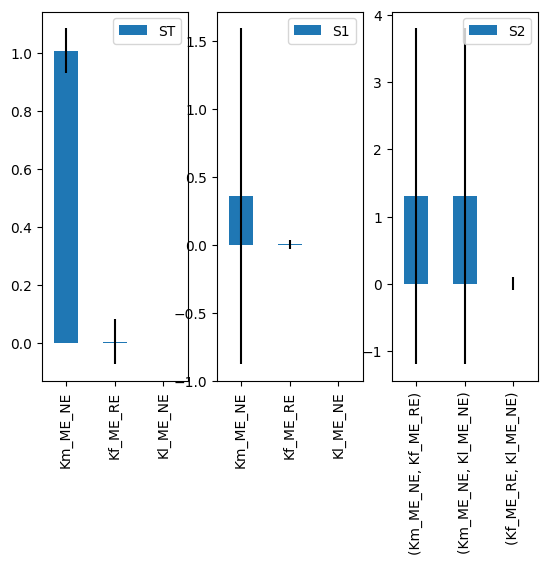

In [34]:
Si.plot()

# ProblemSpec method 
Higher level API (object orientated)
Has built-in parallel processing
For the .evaluate() method to use nproc it needs multiple outputs too, added in this example

In [44]:
import numpy as np

def wrapped_execute_model_multiple_out(X, coeffs_sampled, user_diet_in, animal_input_in, equation_selection_in, feed_library_in, default_coeff_dict=nd.coeff_dict, func=nd.execute_model):
    """
    Modified function to execute the model and return two outputs for sensitivity analysis.

    Parameters are the same as in the provided documentation.
    """
    
    # Initialize a 2D numpy array to hold the two outputs of interest for each set of coefficients
    outputs = np.zeros((X.shape[0], 2))

    # Iterate over each set of parameters in X
    for i, param_set in enumerate(X):
        # Copy the default_coeff_dict to update with current set of parameters
        updated_coeff_dict = default_coeff_dict.copy()
        
        # Update the coefficients being modified in this analysis
        for name, value in zip(coeffs_sampled, param_set):
            updated_coeff_dict[name] = value

        # Execute the model with the updated coefficients
        model_output = func(
            user_diet=user_diet_in,
            animal_input=animal_input_in,
            equation_selection=equation_selection_in,
            feed_library_df=feed_library_in,
            coeff_dict=updated_coeff_dict
        )

        # Extract the two outputs of interest from the ModelOutput object
        output_value1 = model_output.get_value('An_MEavail_Milk')
        output_value2 = model_output.get_value('Mlk_MEout')
        
        # Store both outputs in the outputs array for the current set of parameters
        outputs[i, 0] = output_value1  # For the first output
        outputs[i, 1] = output_value2  # For the second output

    return outputs


In [55]:
import numpy as np
from SALib import ProblemSpec
import nasem_dairy as nd  # Make sure to import your module
from functools import partial

# The coefficients you want to vary in your sensitivity analysis
coeffs_sampled = ['Km_ME_NE', 'Kf_ME_RE', 'Kl_ME_NE']

# Assuming 'user_diet_in', 'animal_input_in', 'equation_selection_in', 'feed_library_in' are defined

# Define the problem specification using your coefficients
# Define the problem statement for SALib
sp = ProblemSpec({
    'names': coeffs_sampled,
    'bounds': [[0, 1]] * len(coeffs_sampled),
    'outputs': ['An_MEavail_Milk', 'Mlk_MEout'],  # Adjust these to your actual output names
})

# Assuming 'user_diet_in', 'animal_input_in', 'equation_selection_in', 'feed_library_in' are defined
# You need to ensure these are defined appropriately before this part of the code

# Define a partial function that includes all the fixed parameters and the default_coeff_dict
evaluate_model_with_fixed_params = partial(
    wrapped_execute_model_multiple_out,
    coeffs_sampled=coeffs_sampled,
    user_diet_in=user_diet_in,
    animal_input_in=animal_input_in,
    equation_selection_in=equation_selection_in,
    feed_library_in=feed_library_in,
    default_coeff_dict=nd.coeff_dict,
    func=nd.execute_model  # Assuming execute_model is a function that returns a ModelOutput object
)



In [64]:

# Run the sampling, model evaluation, and Sobol sensitivity analysis using parallel processing
results = (
    sp.sample_sobol(2**8)  # This will generate Sobol samples
    .evaluate(evaluate_model_with_fixed_params, nprocs=6)  # Evaluate using 2 processes
    .analyze_sobol(nprocs=6)  # Analyze using 2 processes
)

# 'results' will contain the Sobol indices and other related information from the analysis

/Users/dave/miniconda3/envs/NASEM_model_poetry_SALib/lib/python3.12/site-packages/SALib/util/problem.py:210: UserWarning: Parallel evaluation is an experimental feature and may not work.
  warnings.warn(


/Users/dave/miniconda3/envs/NASEM_model_poetry_SALib/lib/python3.12/site-packages/SALib/util/problem.py:398: UserWarning: Parallel analysis is an experimental feature and may not work.
  warnings.warn("Parallel analysis is an experimental feature and may not work.")


In [66]:
results

Samples:
	3 parameters: ['Km_ME_NE', 'Kf_ME_RE', 'Kl_ME_NE']
	2048 evaluations
Outputs:
	2 outputs: ['An_MEavail_Milk', 'Mlk_MEout']
	2048 evaluations
Analysis:
An_MEavail_Milk:
                ST   ST_conf
Km_ME_NE  0.999152  0.038226
Kf_ME_RE  0.000163  0.017444
Kl_ME_NE  0.000000  0.000000:
                S1   S1_conf
Km_ME_NE  0.783928  1.350082
Kf_ME_RE  0.000355  0.035785
Kl_ME_NE  0.000000  0.000000:
                            S2   S2_conf
(Km_ME_NE, Kf_ME_RE)  0.430449  2.721715
(Km_ME_NE, Kl_ME_NE)  0.430016  2.720127
(Kf_ME_RE, Kl_ME_NE) -0.000816  0.023799:
Mlk_MEout:
                ST   ST_conf
Km_ME_NE  0.000000  0.000000
Kf_ME_RE  0.000000  0.000000
Kl_ME_NE  1.009566  0.025293:
                S1   S1_conf
Km_ME_NE  0.000000  0.000000
Kf_ME_RE  0.000000  0.000000
Kl_ME_NE  1.710041  1.283402:
                                S2       S2_conf
(Km_ME_NE, Kf_ME_RE)  0.000000e+00  0.000000e+00
(Km_ME_NE, Kl_ME_NE) -2.220446e-16  3.810471e-16
(Kf_ME_RE, Kl_ME_NE) -2.220446e

array([[<Axes: title={'center': 'An_MEavail_Milk'}>, <Axes: >, <Axes: >],
       [<Axes: title={'center': 'Mlk_MEout'}>, <Axes: >, <Axes: >]],
      dtype=object)

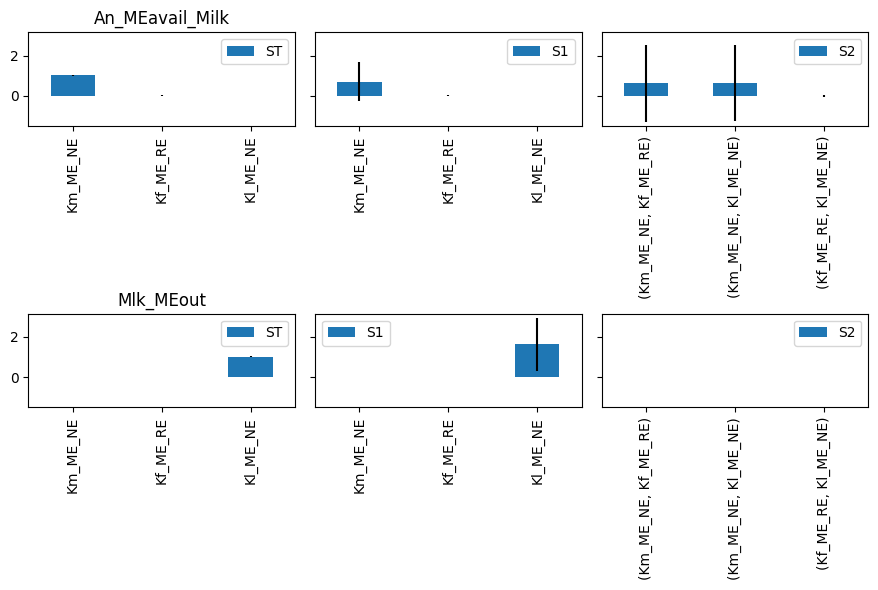

In [58]:
results.plot()

<Axes: title={'center': 'An_MEavail_Milk'}>

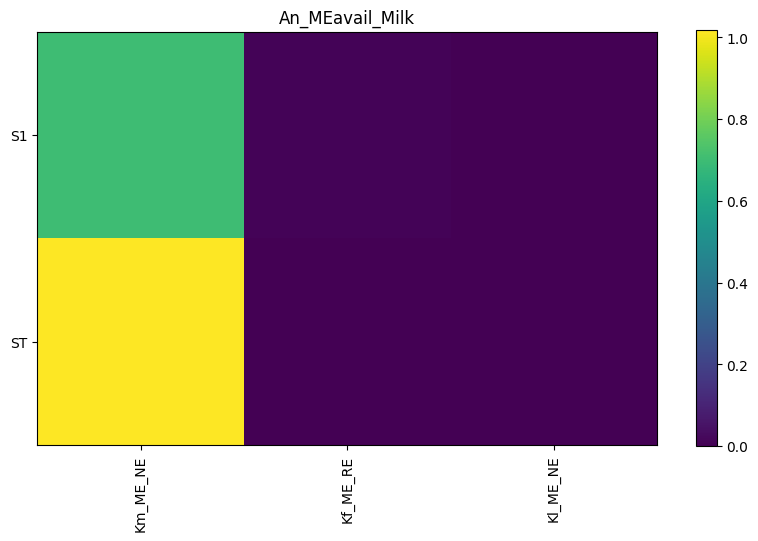

In [59]:
results.heatmap()

array([<Axes: title={'center': 'An_MEavail_Milk'}>,
       <Axes: title={'center': 'Mlk_MEout'}>], dtype=object)

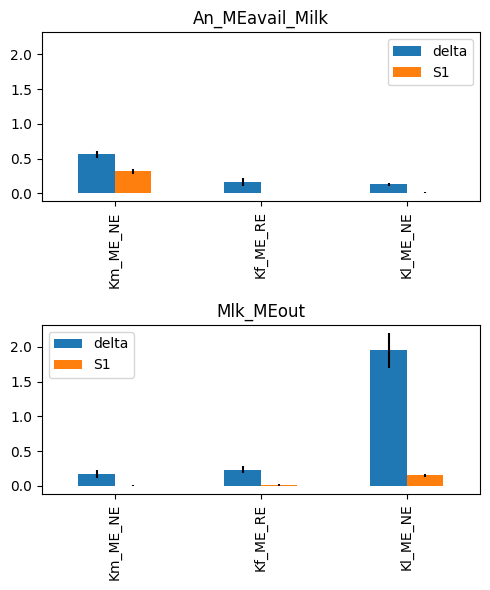

In [60]:
    results.analyze_delta(num_resamples=5)
    results.plot()
    

In [63]:
results.to_df()

[             delta  delta_conf        S1   S1_conf
 Km_ME_NE  0.561540    0.049690  0.316545  0.031558
 Kf_ME_RE  0.163744    0.054114  0.008814  0.003141
 Kl_ME_NE  0.132382    0.019446  0.012368  0.011283,
              delta  delta_conf        S1   S1_conf
 Km_ME_NE  0.171570    0.058909  0.006065  0.009948
 Kf_ME_RE  0.235410    0.049973  0.009616  0.013432
 Kl_ME_NE  1.949596    0.255252  0.151924  0.024646]